In [26]:
# %% ============================================================
# EPA133a - Assignment 1
# Road outlier detection (bad LRP coordinate points) using HAVERSINE distances
# Works with either:
#   A) Roads_InfoAboutEachLRP.csv  (recommended; already long format)
#   B) infrastructure/_roads.tsv   (wide format; one road per row)
#
# Output:
#   - road_outliers.csv : list of suspicious LRP points + diagnostics
#   - (optional) per-road plots if you enable plotting
# ===============================================================

import os
import numpy as np
import pandas as pd

# ---------------------------
# 1) CONFIG (edit these paths)
# ---------------------------

# Prefer long-format input if you have it:
PATH_LRP_LONG = "Roads_InfoAboutEachLRP.csv"

# Wide-format roads file (if you need it):
PATH_ROADS_WIDE = os.path.join("infrastructure", "_roads.tsv")

# Output
OUT_OUTLIERS = "road_outliers.csv"

# Bangladesh bounding box (generous to avoid false positives)
LAT_MIN, LAT_MAX = 19.0, 28.5
LON_MIN, LON_MAX = 87.0, 94.5

# Robust threshold strength (bigger => fewer flags)
# For "double jump" detection:
K_MAD = 8.0

# Minimum MAD to prevent overly tiny thresholds (in km)
MIN_MAD_KM = 0.05  # 50 meters


# ---------------------------
# 2) DISTANCE UTILITIES
# ---------------------------

def haversine_km(lat1, lon1, lat2, lon2):
    """
    Vectorized haversine distance in km.
    Accepts scalars or numpy arrays.
    """
    R = 6371.0088
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))


def mad(x):
    """Median Absolute Deviation (robust scale)."""
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan
    med = np.median(x)
    return np.median(np.abs(x - med))


# ---------------------------
# 3) LOADERS
# ---------------------------

def load_long_format(path):
    """
    Load Roads_InfoAboutEachLRP.csv (one LRP per row).
    This function tries to auto-detect common column names.
    """
    df = pd.read_csv("/Users/shahzebshafi/PycharmProjects/Advanced_Simulation_Bangladesh/Bangladesh_Assignment/data/raw/Roads_InfoAboutEachLRP.csv")

    # Try to find road / chainage / lat / lon / lrp columns
    lower_cols = {c.lower(): c for c in df.columns}

    def pick(*candidates):
        for c in candidates:
            if c in lower_cols:
                return lower_cols[c]
        return None

    road_col = pick("road", "roadname", "road_name", "rid")
    chain_col = pick("chainage", "km", "chainage_km", "chainage_m")
    lat_col = pick("lat", "latitude", "y")
    lon_col = pick("lon", "longitude", "lng", "x")
    lrp_col = pick("lrp", "lrpname", "lrp_name", "lrpid")

    missing = [("road", road_col), ("chainage/km", chain_col), ("lat", lat_col), ("lon", lon_col)]
    missing = [name for name, col in missing if col is None]
    if missing:
        raise ValueError(
            f"Could not auto-detect required columns in {path}. Missing: {missing}. "
            f"Available columns: {list(df.columns)}"
        )

    # Standardize names
    out = df.rename(columns={
        road_col: "road",
        chain_col: "chainage",
        lat_col: "LAT",
        lon_col: "LON",
        **({lrp_col: "LRP"} if lrp_col else {})
    }).copy()

    # Ensure numeric
    out["LAT"] = pd.to_numeric(out["LAT"], errors="coerce")
    out["LON"] = pd.to_numeric(out["LON"], errors="coerce")
    out["chainage"] = pd.to_numeric(out["chainage"], errors="coerce")

    # Drop rows without key info
    out = out.dropna(subset=["road", "LAT", "LON", "chainage"]).reset_index(drop=True)

    # If no LRP column, make a placeholder
    if "LRP" not in out.columns:
        out["LRP"] = "."

    return out[["road", "chainage", "LRP", "LAT", "LON"]]


# ---------------------------
# 4) OUTLIER DETECTION
# ---------------------------

def compute_outliers(roads_long):
    """
    roads_long must have columns: road, chainage, LRP, LAT, LON
    Returns a DataFrame with diagnostic distances and flags.
    """
    df = roads_long.copy()

    # Bounding box flags
    df["flag_bbox"] = ~df["LAT"].between(LAT_MIN, LAT_MAX) | ~df["LON"].between(LON_MIN, LON_MAX)

    # Sort
    df = df.sort_values(["road", "chainage"]).reset_index(drop=True)

    grp = df.groupby("road", sort=False)

    # Prev/next coords per road
    df["LAT_prev"] = grp["LAT"].shift(1)
    df["LON_prev"] = grp["LON"].shift(1)
    df["LAT_next"] = grp["LAT"].shift(-1)
    df["LON_next"] = grp["LON"].shift(-1)

    # Distances to prev and next (km)
    df["d_prev_km"] = haversine_km(df["LAT_prev"], df["LON_prev"], df["LAT"], df["LON"])
    df["d_next_km"] = haversine_km(df["LAT"], df["LON"], df["LAT_next"], df["LON_next"])

    # Road-level robust threshold using all step distances on that road
    def road_threshold(sub):
        steps = pd.concat([sub["d_prev_km"], sub["d_next_km"]]).dropna().to_numpy()
        if len(steps) == 0:
            return np.nan
        med = np.median(steps)
        m = mad(steps)
        if np.isnan(m) or m < MIN_MAD_KM:
            m = MIN_MAD_KM
        return med + K_MAD * m

    df["thr_km"] = grp.apply(road_threshold).reset_index(level=0, drop=True)

    # Double-jump signature: both adjacent edges are large -> point is likely wrong
    df["flag_double_jump"] = (df["d_prev_km"] > df["thr_km"]) & (df["d_next_km"] > df["thr_km"])

    # Endpoint extreme jumps: if outlier is near start/end, double-jump may not trigger
    df["flag_extreme_jump"] = (df["d_prev_km"] > (2.0 * df["thr_km"])) | (df["d_next_km"] > (2.0 * df["thr_km"]))

    # Final
    df["flag_outlier"] = df["flag_bbox"] | df["flag_double_jump"] | df["flag_extreme_jump"]

    # Keep diagnostics
    return df[[
        "road", "chainage", "LRP", "LAT", "LON",
        "d_prev_km", "d_next_km", "thr_km",
        "flag_bbox", "flag_double_jump", "flag_extreme_jump", "flag_outlier"
    ]]


# ---------------------------
# 5) MAIN
# ---------------------------

def main():
    # Prefer long-format file if it exists; otherwise fall back to wide format
    print(f"Loading long-format LRP file: {PATH_LRP_LONG}")
    roads_long = load_long_format(PATH_LRP_LONG)


    print(f"Loaded {len(roads_long):,} LRP points across {roads_long['road'].nunique():,} roads.")

    flagged = compute_outliers(roads_long)
    outliers = flagged[flagged["flag_outlier"]].copy()

    print(f"Flagged {len(outliers):,} suspicious LRP points.")
    outliers.to_csv(OUT_OUTLIERS, index=False)
    print(f"Saved: {OUT_OUTLIERS}")

    # Show worst jumps (helpful for debugging)
    print("\nTop 15 largest d_prev_km:")
    print(flagged.sort_values("d_prev_km", ascending=False).head(15)[
        ["road", "chainage", "LRP", "d_prev_km", "d_next_km", "thr_km", "flag_outlier"]
    ])

    print("\nTop 15 largest d_next_km:")
    print(flagged.sort_values("d_next_km", ascending=False).head(15)[
        ["road", "chainage", "LRP", "d_prev_km", "d_next_km", "thr_km", "flag_outlier"]
    ])

if __name__ == "__main__":
    main()

Loading long-format LRP file: Roads_InfoAboutEachLRP.csv
Loaded 51,926 LRP points across 877 roads.
Flagged 39 suspicious LRP points.
Saved: road_outliers.csv

Top 15 largest d_prev_km:
        road  chainage      LRP   d_prev_km   d_next_km  thr_km  flag_outlier
32314  Z3709    19.080  LRP019a  444.931681    0.391149     NaN         False
42107  Z6813    59.950     LRPE  444.786503         NaN     NaN         False
32313  Z3709    18.930   LRP019  444.245955  444.931681     NaN         False
22880  Z1084    50.000   LRP050  334.936093    0.956895     NaN         False
5951      N5   526.013   LRP524  334.542854    0.008838     NaN         False
32939  Z4019    11.000   LRP011  333.748951  333.489494     NaN         False
34736  Z5010    23.687   LRP024  333.743198    0.617040     NaN         False
2468      N2    41.306  LRP042a  333.616131  333.301153     NaN         False
45627  Z7603    18.321  LRP018a  333.585245    0.664184     NaN         False
34735  Z5010    23.121  LRP023b  3

/var/folders/yh/mq6pqxds2kv8kwp16thtgj800000gn/T/ipykernel_42474/2359103171.py:172: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["thr_km"] = grp.apply(road_threshold).reset_index(level=0, drop=True)


In [27]:
import matplotlib.pyplot as plt

# Run the pipeline (outside main)
roads_long = load_long_format(PATH_LRP_LONG)
flagged = compute_outliers(roads_long)

# (Optional) if you later create a cleaned version, assign it to df_clean
# df_clean = ...

/var/folders/yh/mq6pqxds2kv8kwp16thtgj800000gn/T/ipykernel_42474/2359103171.py:172: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["thr_km"] = grp.apply(road_threshold).reset_index(level=0, drop=True)


In [1]:
import matplotlib.pyplot as plt

road_id = "N1"

# Raw road geometry
n_raw = roads_long[roads_long["road"] == road_id].sort_values("chainage")

# Flagged outliers on that road
n_flag = flagged[(flagged["road"] == road_id) & (flagged["flag_outlier"])].sort_values("chainage")

plt.figure(figsize=(12, 6))

# Raw polyline
plt.plot(n_raw["LON"], n_raw["LAT"], "-", linewidth=1, alpha=0.6, label="Raw")

# Outliers as red dots
if len(n_flag) > 0:
    plt.scatter(n_flag["LON"], n_flag["LAT"], s=35, marker="o", label="Flagged outliers")

plt.title(f"{road_id} Road: Raw geometry + flagged outliers", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'roads_long' is not defined

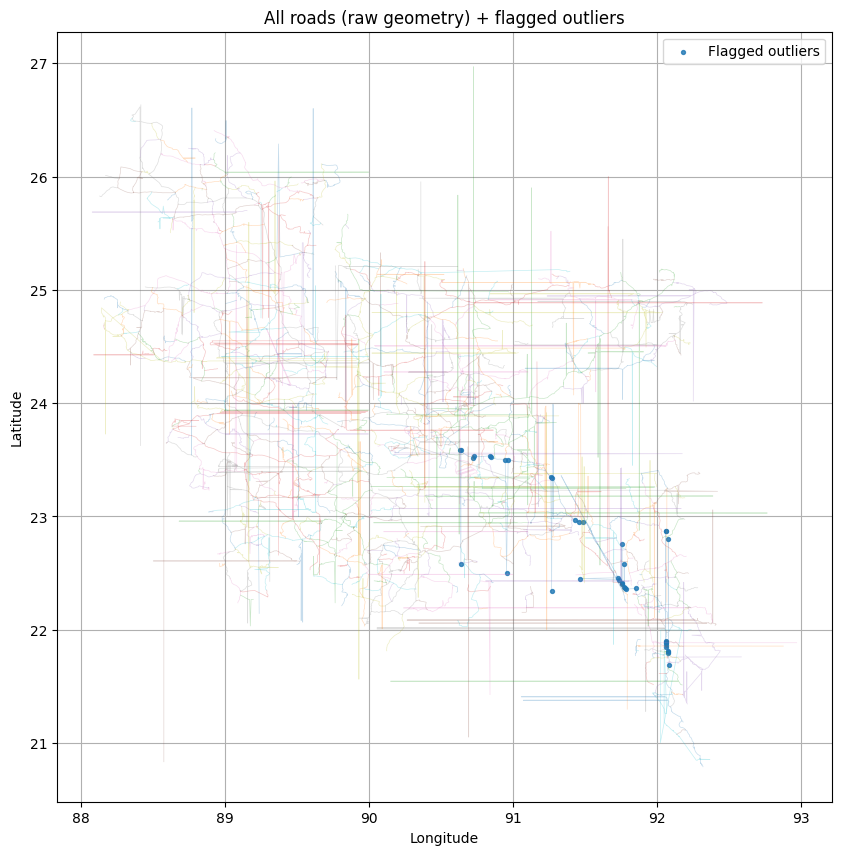

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# plot each road as a thin line
for road, sub in roads_long.groupby("road"):
    sub = sub.sort_values("chainage")
    plt.plot(sub["LON"], sub["LAT"], linewidth=0.5, alpha=0.25)

# overlay all outliers
all_flag = flagged[flagged["flag_outlier"]]
plt.scatter(all_flag["LON"], all_flag["LAT"], s=8, alpha=0.8, label="Flagged outliers")

plt.title("All roads (raw geometry) + flagged outliers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()